## Importing libraries

In [13]:
import pandas as pd # to store data efficiently
import numpy as np # to handle numerical operations
import random # to generate random numbers
import os # to handle operations regarding file system
import wget # to download locally images
from ultralytics import YOLO # to import YOLO model
from tqdm import tqdm # to visualize loop progressions
import matplotlib.pyplot as plt


## Getting images list with people from COCO dataset

In [ ]:
anns_df = pd.read_csv('person_anns.csv')

In [ ]:
img_url_list = list(anns_df['img_url'].unique())
print(len(img_url_list))

58883


## Random sampling from that list and download locally images

In [4]:
random.seed(24) # to use same collection of images
img_sample = random.sample(img_url_list, 2000)

### Downloads images inside list

In [5]:
# Changes cwd (to download image via wget in) and then changes it back
old_cwd = os.getcwd()
new_cwd = old_cwd+'/imgs'
os.chdir(new_cwd)
for url in tqdm(img_sample):
    try:
        file_name = url.split('/')[-1]
        file_path = os.path.join(new_cwd, file_name)
        
        if not os.path.exists(file_path):
            wget.download(url)
    except Exception as e:
        print(f"\nError in download of {url}: {e}")
os.chdir(old_cwd)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [03:54<00:00,  8.54it/s] 


In [6]:
model = YOLO("yolo11n.pt")

In [7]:
result = model.predict(source="./imgs")



WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/2001 c:\Users\fedep\OneDrive\Desktop\Universita'\Year 2\PER\FemaleObjectificationInMovies\imgs\000000000326.jpg: 448x640 1 person, 1 tennis racket, 1 wine glass, 768.1ms
image 2/2001 c:\Users\fedep\OneDrive\Desktop\Universita'\Year 2\PER\FemaleObjectificationInMovies\imgs\000000001149.jpg: 448x640 13 persons, 6 ties, 180.0ms
image 3/2001 c:\Users\fedep\OneDrive\Desktop\Universita'\Year 2\PER\FemaleObjectificationInMovies\imgs\000000001200.jpg: 64

In [8]:
def confidence_score(result_img):
    detection_list = []
    for res in result_img:
        img_id = res.path.split('\\')[-1].strip('.jpg').lstrip('0')
        
        # Get mask for class 0
        class_mask = res.boxes.cls == 0
        
        # Get all relevant data in one go
        confidences = res.boxes.conf[class_mask]
        dimensions = res.boxes.xywhn[class_mask]
        
        # Print results using zip to iterate both arrays simultaneously
        for index, (conf, dim) in enumerate(zip(confidences, dimensions)):
            detection_dict = {}  # Crea un nuovo dizionario per ogni rilevamento
            detection_dict['Img_ID'] = img_id
            detection_dict['Confidence'] = conf.item()
            detection_dict['Dimensions'] = dim.tolist()
            detection_dict['ID'] = f'{img_id}{index}'
            detection_list.append(detection_dict)
        
        # Add specific case if no person is detected
        if len(confidences) == 0:
            detection_dict = {  
                'Img_ID': img_id,
                'Confidence': 0,
                'Dimensions': [],
                'ID': img_id
            }
            detection_list.append(detection_dict)
    
    return detection_list


In [9]:
data = confidence_score(result)

In [ ]:
df = pd.DataFrame(data).set_index('ID')

In [11]:
df['x_center'] = df['Dimensions'].apply(lambda x: x[0] if x else np.nan)
df['y_center'] = df['Dimensions'].apply(lambda x: x[1] if x else np.nan)
df['width'] = df['Dimensions'].apply(lambda x: x[2] if x else np.nan)
df['height'] = df['Dimensions'].apply(lambda x: x[3] if x else np.nan)
df = df.drop(['Dimensions'], axis=1)

In [14]:
grouped_df = df.groupby('Img_ID')[['Confidence']].mean()

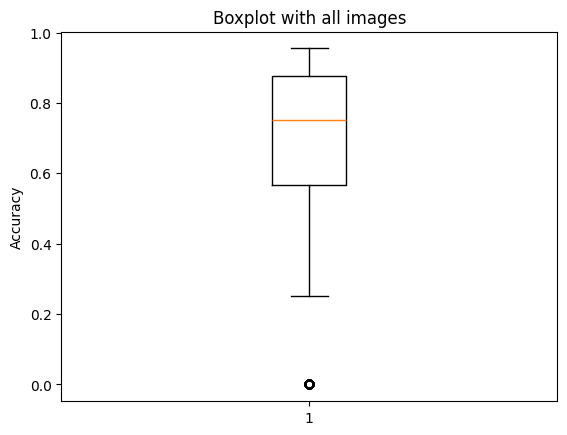

In [16]:
plt.boxplot(grouped_df)

plt.title("Boxplot with all images")
plt.ylabel("Accuracy")
plt.show()